In [12]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.collections import LineCollection  # 新增导入LineCollection

habitat_current=xr.open_dataarray("habitat_maxent_current.nc")
habitat_585=xr.open_dataarray("habitat_maxent_ssp585dec100.nc")
habitat_sum=xr.open_dataarray("habitat_maxent_sum.nc")
PC31 = xr.open_dataset("polar_31_pred.nc")
PC42 = xr.open_dataset("polar_42_pred.nc")


PC31_his = PC31.where(PC31.Years <=2024, drop=True)
PC31_pred = PC31.where(PC31.Years >2024, drop=True)

PC42_his = PC42.where(PC42.Years <=2024, drop=True)
PC42_pred = PC42.where(PC42.Years >2024, drop=True)

# # Define a function to filter out locations with less than 5 non-nan values
# def filter_by_count(ds, min_count=20):
#     """
#     Filter a dataset to keep only locations (Longitude, Latitude) that have 
#     at least min_count non-NaN values across time and Years dimensions.
#     """
#     # Count non-nan values across time and Years dimensions for each lat-lon position
#     count_mhw = (~np.isnan(ds.mhw)).sum(dim=['time', 'Years'])
#     count_nan = (~np.isnan(ds.nan)).sum(dim=['time', 'Years'])
    
#     # Create masks for locations with at least min_count non-nan values
#     mask_mhw = count_mhw >= min_count
#     mask_nan = count_nan >= min_count
    
#     # Apply the masks to the dataset
#     ds_filtered = ds.copy()
#     ds_filtered['mhw'] = ds.mhw.where(mask_mhw)
#     ds_filtered['nan'] = ds.nan.where(mask_nan)
    
#     # Also filter clm if it exists in the dataset
#     if 'clm' in ds:
#         count_clm = (~np.isnan(ds.clm)).sum(dim=['time', 'Years'])
#         mask_clm = count_clm >= min_count
#         ds_filtered['clm'] = ds.clm.where(mask_clm)
    
#     return ds_filtered

# # Apply filtering to PC31 and PC42 datasets
# PC31_filtered = filter_by_count(PC31)
# PC42_filtered = filter_by_count(PC42)

# # Split into historical and predicted periods as before
# PC31_his = PC31_filtered.where(PC31_filtered.Years <= 2024, drop=True)
# PC31_pred = PC31_filtered.where(PC31_filtered.Years > 2024, drop=True)

# PC42_his = PC42_filtered.where(PC42_filtered.Years <= 2024, drop=True)
# PC42_pred = PC42_filtered.where(PC42_filtered.Years > 2024, drop=True)

habitat_maxent_current_regions=xr.open_dataset("habitat_maxent_current_regions.nc")
habitat_maxent_585_regions=xr.open_dataset("habitat_maxent_ssp585dec100_regions.nc")

In [13]:
def plot_polar_map2(data, title, figname, cbar_min=0, cbar_max=100, overlay_data=None, linewidth=0.5, alpha=0.5):  # 新增overlay_data参数


    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # 创建圆形边界消除外围区域
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # 地理特征（保持不变）
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        facecolor='none',
                                        edgecolor='black',
                                        linewidth=2,
                                        linestyle='-')
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        facecolor='lightgray',
                                        edgecolor='none')
    ax.add_feature(land, zorder=0)
    ax.add_feature(coast, zorder=1)

    # 主数据绘图（保持不变）
    mesh = data.sel(Latitude=slice(60, 90)).plot.pcolormesh(
        ax=ax,
        cmap='Reds',
        robust=True,
        extend='both',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=2
    )
    mesh.set_clim(cbar_min, cbar_max)

    # 新增斜线覆盖层逻辑（改进版）
    if overlay_data is not None:
        # 解包经纬度坐标和数据值
        lons = overlay_data['Longitude'].values
        lats = overlay_data['Latitude'].values
        values = overlay_data.values  # 提取数据矩阵
        
        # 创建坐标网格并扁平化处理
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        flat_lons = lon_grid.ravel()
        flat_lats = lat_grid.ravel()
        flat_values = values.ravel()  # 展平为1D数组
        
        # 生成有效性掩膜
        valid_mask31 = ~np.isnan(flat_values)  # 布尔型过滤器
        
        # 矢量化的坐标筛选
        valid_lons = flat_lons[valid_mask31]
        valid_lats = flat_lats[valid_mask31]
        
        # 生成线段集合（EDGE走向调整）
        delta = 0.25  # 增加线长补偿投影形变
        segments = [
            [ (lon-delta, lat+delta), (lon+delta, lat-delta) ] 
            for lon, lat in zip(valid_lons, valid_lats)  # 仅过滤后的点
        ]
        
        # 参数优化后的线型设置
        lc = LineCollection(
            segments,
            colors='black',
            linewidths=linewidth,          # 更细的线条
            linestyles=(0, (2, 3)),  # 断续线（2点实线+1点空白）
            # linestyles='solid',  # 实线
            transform=ccrs.PlateCarree(),
            zorder=4,
            alpha=alpha               # 增加透明度避免过重
        )
        ax.add_collection(lc)

    # 其余部分（颜色条、标签、标题等保持原样）
    cbar = plt.colorbar(mesh, orientation='vertical', pad=0.05, shrink=0.7)
    cbar.set_label('Mortality Rate (%)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.8,
        color='gray',
        alpha=0.6,
        linestyle=':',
        zorder=3
    )
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 5))
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.top_labels = True
    gl.right_labels = False


    plt.title(title, 
            fontsize=14, 
            pad=25, 
            fontweight='bold',
            color='navy')
    
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import matplotlib.patches as mpatches

def plot_polar_map3(ax, data, title, cbar_min=0, cbar_max=100, 
                   overlay_data=None, linewidth=0.5, alpha=0.5,
                   add_colorbar=False, colormap='RdYlBu_r'):  # 新增参数控制色阶


    # 设置极地投影范围
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # 优化圆形边界
    theta = np.linspace(0, 2*np.pi, 200)  # 增加采样点使边界更平滑
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # 增强地理特征显示（重点修改部分）
    # coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
    #                                     facecolor='none',
    #                                     edgecolor='black',
    #                                     linewidth=2,
    #                                     linestyle='-')
    # land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
    #                                     facecolor='lightgray',
    #                                     edgecolor='none')
    # ax.add_feature(land, zorder=0)
    # ax.add_feature(coast, zorder=1)
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        facecolor='#EBEBEB',  # 更深的浅灰色
        edgecolor='none'
    )
    coastline_feature = cfeature.NaturalEarthFeature(
        'physical', 'coastline', '10m',
        facecolor='none',
        edgecolor='#222222',  # 深灰色
        linewidth=1.5         # 加粗海岸线
    )
    ax.add_feature(land_feature, zorder=1)
    ax.add_feature(coastline_feature, zorder=2)

    # 使用改进的色阶方案
    cmap = plt.get_cmap(colormap).copy()  # 红黄蓝渐变色
    # cmap.set_bad(color='#F0F0F0', alpha=0.8)  # 调整缺失值颜色

    # 绘制主数据
    mesh = data.sel(Latitude=slice(60, 90)).plot.pcolormesh(
        ax=ax,
        cmap=cmap,
        robust=True,
        extend='both',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=3,
        alpha=0.95
    )
    mesh.set_clim(cbar_min, cbar_max)

    # 优化覆盖层斜线
    if overlay_data is not None:
        lons = overlay_data['Longitude'].values
        lats = overlay_data['Latitude'].values
        values = overlay_data.values
        
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        flat_lons = lon_grid.ravel()
        flat_lats = lat_grid.ravel()
        flat_values = values.ravel()
        
        valid_mask31 = ~np.isnan(flat_values)
        valid_lons = flat_lons[valid_mask31]
        valid_lats = flat_lats[valid_mask31]
        valid_lons = valid_lons[::2]
        valid_lats = valid_lats[::2]    
            
        delta = 0.3  # 减小线段长度
        segments = [
            [(lon-delta, lat+delta), (lon+delta, lat-delta)]
            for lon, lat in zip(valid_lons, valid_lats)
        ]
        
        lc = LineCollection(
            segments,
            colors='black',  
            linewidths=linewidth*0.8,  # 减小线宽
            linestyles=(0, (3, 3)),  # 更长的虚线间隔
            transform=ccrs.PlateCarree(),
            zorder=4,
            alpha=0.6  # 降低透明度
        )
        ax.add_collection(lc)
        
    # 专业颜色条设置
    # cbar = plt.colorbar(
    #     mesh,
    #     orientation='vertical',
    #     pad=0.08,
    #     shrink=0.65,
    #     ax=ax,
    #     ticks=np.linspace(cbar_min, cbar_max, 6),
    #     drawedges=True
    # )
    # cbar.set_label('Mortality Rate (%)', fontsize=11, weight='bold', labelpad=12)
    # cbar.ax.tick_params(labelsize=9, width=0.8)
    # cbar.outline.set_linewidth(0.8)

    # 增强网格线系统（重点修改）
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=0.7,  # 加粗线宽
        color='#444444',  # 加深颜色
        alpha=0.8,
        linestyle=':',   # 点线样式
        zorder=5
    )
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 10))
    gl.xlabel_style = {'size': 9, 'color': '#222222'}
    gl.ylabel_style = {'size': 9, 'color': '#222222'}
    
    # 其他设置保持不变...
    
    gl.top_labels = False
    gl.right_labels = False
    
    gl.rotate_labels = False

    # 优化标题排版
    ax.set_title(
        title,
        fontsize=13,
        pad=28, 
        weight='bold',
        color='#2A2A2A',  # 深灰色替代海军蓝
        loc='left'
    )

    # 添加比例尺（示例）
    scale_bar(ax)  # 需要自定义比例尺函数

    return mesh  # 返回mesh对象用于共享色阶
        
    

def scale_bar(ax, length=1000, location=(0.15, 0.1)):
    """添加比例尺"""
    # 实现比例尺绘制逻辑
    pass

In [15]:
def plot_line(ax, years,data1,data2,data3):
# 使用颜色盲友好色系
        ax.plot(years, data1, 
                color='#e41a1c', linestyle='-', 
                label='During MHW')
        ax.plot(years, data2,
                color='#377eb8', linestyle='-',
                label='Outside MHW')
        ax.plot(years, data3,
                color='#984ea3', linestyle='-',
                label='Years Anomaly')
        # 坐标轴优化
        ax.set_xlabel('Year', labelpad=5)
        ax.set_ylabel('Mortality Rate (%)', labelpad=8)
        ax.set_ylim(0, 100)

        # 设置科学刻度样式
        ax.tick_params(axis='both', which='major', direction='out', length=4)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d%%'))

        # 优化图例布局

        ax.legend(
                frameon=True, 
                loc='upper right',
                # bbox_to_anchor=(0.98, 1),  # 移至绘图区右侧
                borderaxespad=0.,
                ncol=1)

        # 美化边框和网格
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, which='major', axis='y', 
                linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_title(
        'Mortality Timeseries',
        fontsize=13,
        pad=28, 
        weight='bold',
        color='#2A2A2A',  # 深灰色替代海军蓝
        loc='left',
    )

In [16]:
PC31_annual_mhw=PC31.mhw.mean(dim=['time'], skipna=True)
PC31_annual_nan=PC31.nan.mean(dim=['time'], skipna=True)
PC31_annual_ano=PC31_annual_mhw-PC31_annual_nan


PC42_annual_mhw=PC42.mhw.mean(dim=['time'], skipna=True)
PC42_annual_nan=PC42.nan.mean(dim=['time'], skipna=True)
PC42_annual_ano=PC42_annual_mhw-PC42_annual_nan


habitat_used = habitat_585

habitat_used = habitat_used.assign_coords(
    Latitude=PC31_annual_mhw.Latitude,
    Longitude=PC31_annual_mhw.Longitude
)


filtered_PC31_annual_mhw = PC31_annual_mhw.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)
filtered_PC31_annual_nan = PC31_annual_nan.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)
filtered_PC31_annual_ano = PC31_annual_ano.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)

filtered_PC42_annual_mhw = PC42_annual_mhw.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)
filtered_PC42_annual_nan = PC42_annual_nan.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)
filtered_PC42_annual_ano = PC42_annual_ano.where(habitat_used.notnull()).mean(dim=['Latitude','Longitude'], skipna=True)

years = filtered_PC31_annual_mhw.Years.values


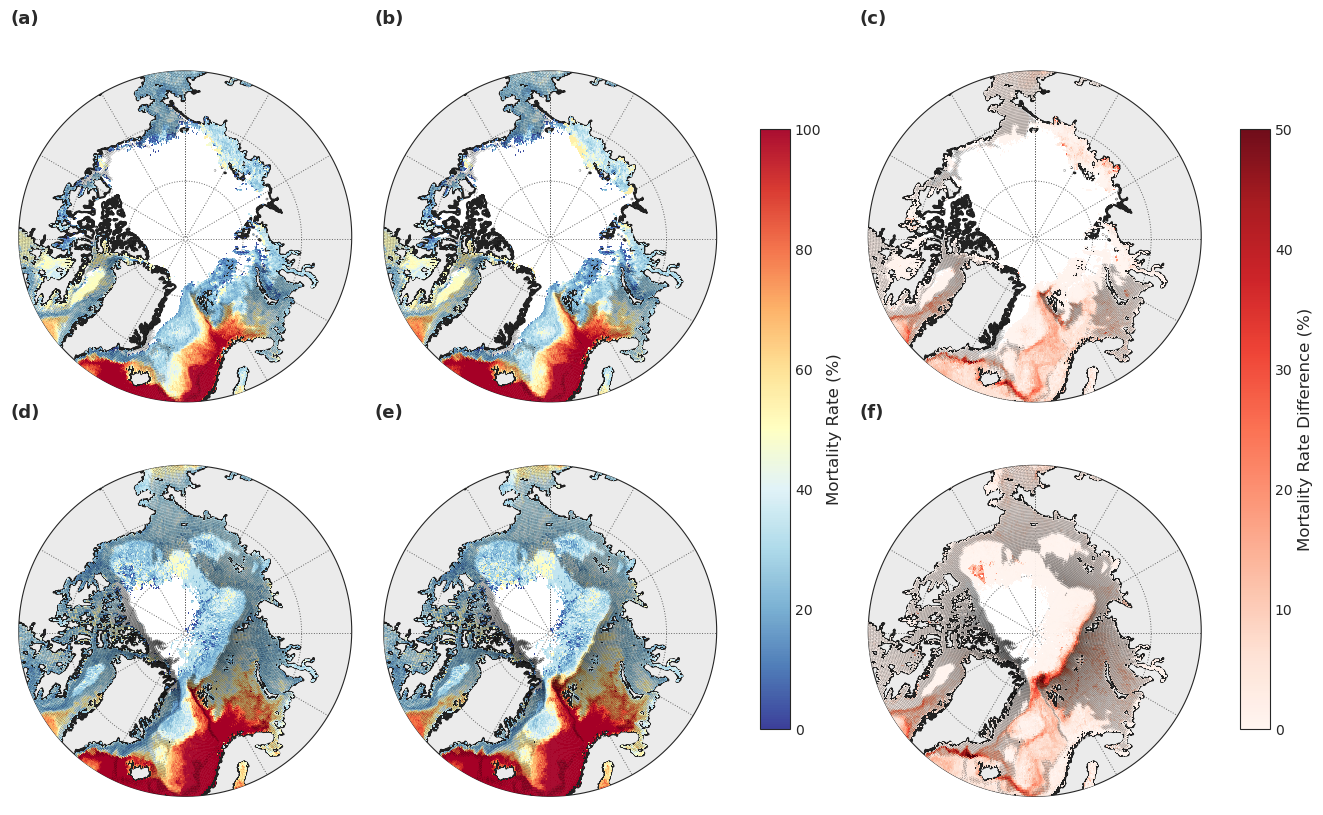

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl
fig = plt.figure(figsize=(15,10))
main_gs = gridspec.GridSpec(
    2, 4, figure=fig,
    width_ratios=[1, 1, 0.3, 1],  # 第3列是间隙，第4列是第三子图列
    left=0.1, right=0.9,          # 主区域占据宽度的60%（左侧10%到70%）
    wspace=0.05, hspace=0.05,     # 列间距极小，行间距极小
    height_ratios=[1, 1]
)
# 设置全局字体和样式
plt.style.use('seaborn-v0_8-white')
mpl.rcParams.update({
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
})


# 添加前6个轴（根据你的实际需求调整投影参数）
ax1 = fig.add_subplot(main_gs[0, 0], projection=ccrs.NorthPolarStereo(0))
ax2 = fig.add_subplot(main_gs[0, 1], projection=ccrs.NorthPolarStereo(0))
ax3 = fig.add_subplot(main_gs[0, 3], projection=ccrs.NorthPolarStereo(0))  # 第三列位于第4列
ax4 = fig.add_subplot(main_gs[1, 0], projection=ccrs.NorthPolarStereo(0))
ax5 = fig.add_subplot(main_gs[1, 1], projection=ccrs.NorthPolarStereo(0))
ax6 = fig.add_subplot(main_gs[1, 3], projection=ccrs.NorthPolarStereo(0))  # 第三列位于第4列




mapmor_mhw_his=PC31_his.mhw.mean(dim=['Years','time'], skipna=True)
mapmor_nan_his=PC31_his.nan.mean(dim=['Years','time'], skipna=True)
mapmor_ano_his=mapmor_mhw_his-mapmor_nan_his
mapmor_mhw_pred=PC31_pred.mhw.mean(dim=['Years','time'], skipna=True)
mapmor_nan_pred=PC31_pred.nan.mean(dim=['Years','time'], skipna=True)
mapmor_ano_pred=mapmor_mhw_pred-mapmor_nan_pred

# 调用绘图函数
mesh1=plot_polar_map3(ax1, mapmor_nan_his,title="(a)", overlay_data=habitat_current, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax2, mapmor_mhw_his,title="(b)", overlay_data=habitat_current, cbar_max=100, linewidth=0.3, alpha=0.8 )
mesh2=plot_polar_map3(ax3, mapmor_ano_his,title="(c)", overlay_data=habitat_current, cbar_min=0, cbar_max=50, linewidth=0.3, alpha=0.8, colormap='Reds')

plot_polar_map3(ax4, mapmor_nan_pred, "(d)", overlay_data=habitat_585, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax5, mapmor_mhw_pred,title="(e)", overlay_data=habitat_585, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax6, mapmor_ano_pred,title="(f)", overlay_data=habitat_585, cbar_min=0, cbar_max=50, linewidth=0.3, alpha=0.8, colormap='Reds')

# 在figure层面创建专门colorbar轴
# cbar_ax1 = fig.add_axes([
#     0.6,   # 左边界位置
#     0.2,   # 底部位置
#     0.02,   # 宽度
#     0.6     # 高度
# ])

cbar_ax1 = fig.add_axes([
    0.6 ,  # 左边界：间隙起始位置 + 偏移
    0.2,               # 底部位置（根据需求调整）
    0.02,              # 宽度
    0.6                # 高度
])

# 在最右侧添加第二个colorbar（cbar_ax2）
cbar_ax2 = fig.add_axes([
    0.92,   # 左边界：主区域右侧（right=0.7）之后
    0.2,    # 底部位置
    0.02,   # 宽度
    0.6     # 高度
])


cbar1 = fig.colorbar(mesh1, cax=cbar_ax1)
cbar1.set_label('Mortality Rate (%)', fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# cbar_ax2 = fig.add_axes([
#     0.9,   # 左边界位置
#     0.2,   # 底部位置
#     0.02,   # 宽度
#     0.6     # 高度
# ])

cbar2 = fig.colorbar(mesh2, cax=cbar_ax2)
cbar2.set_label('Mortality Rate Difference (%)', fontsize=12)
cbar2.ax.tick_params(labelsize=10)
# 调整布局并保存
# 调整布局
# plot_line(ax7,years,filtered_PC31_annual_mhw,filtered_PC31_annual_nan,filtered_PC31_annual_ano)


plt.subplots_adjust(wspace=0.05)  # 缩小子图间距
plt.savefig("figures/map_31_all.png", dpi=300, bbox_inches='tight')
plt.show()

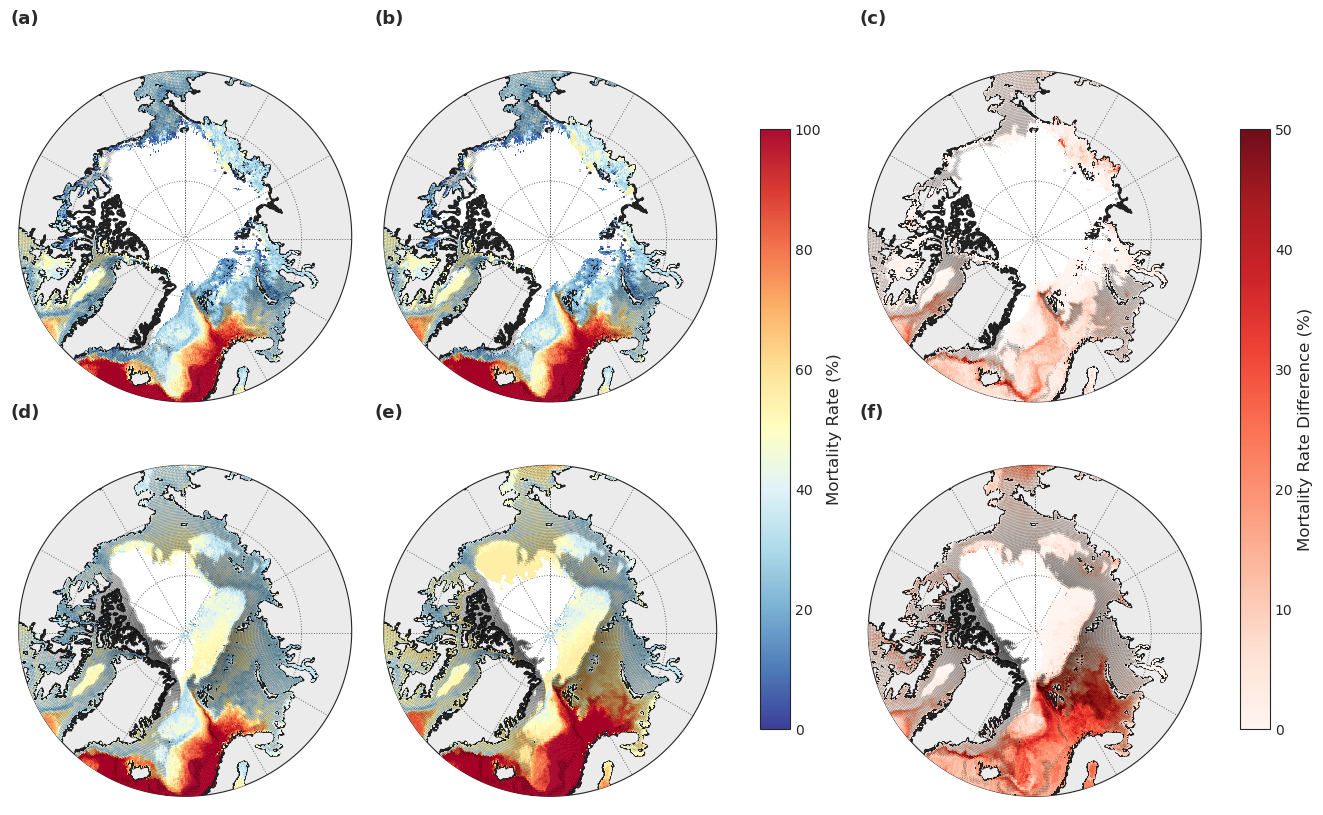

In [26]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl
fig = plt.figure(figsize=(15,10))
main_gs = gridspec.GridSpec(
    2, 4, figure=fig,
    width_ratios=[1, 1, 0.3, 1],  # 第3列是间隙，第4列是第三子图列
    left=0.1, right=0.9,          # 主区域占据宽度的60%（左侧10%到70%）
    wspace=0.05, hspace=0.05,     # 列间距极小，行间距极小
    height_ratios=[1, 1]
)
# 设置全局字体和样式
plt.style.use('seaborn-v0_8-white')
mpl.rcParams.update({
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
})


# 添加前6个轴（根据你的实际需求调整投影参数）
ax1 = fig.add_subplot(main_gs[0, 0], projection=ccrs.NorthPolarStereo(0))
ax2 = fig.add_subplot(main_gs[0, 1], projection=ccrs.NorthPolarStereo(0))
ax3 = fig.add_subplot(main_gs[0, 3], projection=ccrs.NorthPolarStereo(0))  # 第三列位于第4列
ax4 = fig.add_subplot(main_gs[1, 0], projection=ccrs.NorthPolarStereo(0))
ax5 = fig.add_subplot(main_gs[1, 1], projection=ccrs.NorthPolarStereo(0))
ax6 = fig.add_subplot(main_gs[1, 3], projection=ccrs.NorthPolarStereo(0))  # 第三列位于第4列



mapmor_mhw_his=PC42_his.mhw.mean(dim=['Years','time'], skipna=True)
mapmor_nan_his=PC42_his.nan.mean(dim=['Years','time'], skipna=True)
mapmor_ano_his=mapmor_mhw_his-mapmor_nan_his
mapmor_mhw_pred=PC42_pred.mhw.mean(dim=['Years','time'], skipna=True)
mapmor_nan_pred=PC42_pred.nan.mean(dim=['Years','time'], skipna=True)
mapmor_ano_pred=mapmor_mhw_pred-mapmor_nan_pred

# 调用绘图函数
mesh1=plot_polar_map3(ax1, mapmor_nan_his,title="(a)", overlay_data=habitat_current, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax2, mapmor_mhw_his,title="(b)", overlay_data=habitat_current, cbar_max=100, linewidth=0.3, alpha=0.8 )
mesh2=plot_polar_map3(ax3, mapmor_ano_his,title="(c)", overlay_data=habitat_current, cbar_min=0, cbar_max=50, linewidth=0.3, alpha=0.8, colormap='Reds')

plot_polar_map3(ax4, mapmor_nan_pred, "(d)", overlay_data=habitat_585, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax5, mapmor_mhw_pred,title="(e)", overlay_data=habitat_585, cbar_max=100, linewidth=0.3, alpha=0.8 )
plot_polar_map3(ax6, mapmor_ano_pred,title="(f)", overlay_data=habitat_585, cbar_min=0, cbar_max=50, linewidth=0.3, alpha=0.8, colormap='Reds')

# 在figure层面创建专门colorbar轴
# cbar_ax1 = fig.add_axes([
#     0.6,   # 左边界位置
#     0.2,   # 底部位置
#     0.02,   # 宽度
#     0.6     # 高度
# ])

cbar_ax1 = fig.add_axes([
    0.6 ,  # 左边界：间隙起始位置 + 偏移
    0.2,               # 底部位置（根据需求调整）
    0.02,              # 宽度
    0.6                # 高度
])

# 在最右侧添加第二个colorbar（cbar_ax2）
cbar_ax2 = fig.add_axes([
    0.92,   # 左边界：主区域右侧（right=0.7）之后
    0.2,    # 底部位置
    0.02,   # 宽度
    0.6     # 高度
])


cbar1 = fig.colorbar(mesh1, cax=cbar_ax1)
cbar1.set_label('Mortality Rate (%)', fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# cbar_ax2 = fig.add_axes([
#     0.9,   # 左边界位置
#     0.2,   # 底部位置
#     0.02,   # 宽度
#     0.6     # 高度
# ])

cbar2 = fig.colorbar(mesh2, cax=cbar_ax2)
cbar2.set_label('Mortality Rate Difference (%)', fontsize=12)
cbar2.ax.tick_params(labelsize=10)
# 调整布局并保存
# 调整布局
# plot_line(ax7,years,filtered_PC42_annual_mhw,filtered_PC42_annual_nan,filtered_PC42_annual_ano)


plt.subplots_adjust(wspace=0.05)  # 缩小子图间距
plt.savefig("figures/map_42_all.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
PC31_pred.mhw.mean(dim=['Years','time']).mean()

<xarray.DataArray 'mhw' ()> Size: 8B
array(46.53614986)

In [20]:
PC31_pred_mhw_mean=PC31_pred.mhw.mean()
PC31_pred_nan_mean=PC31_pred.nan.mean()
PC31_pred_ano_mean=PC31_pred_mhw_mean-PC31_pred_nan_mean
print(PC31_pred_mhw_mean)
print(PC31_pred_nan_mean)
print(PC31_pred_ano_mean)

<xarray.DataArray 'mhw' ()> Size: 8B
array(61.37711782)
<xarray.DataArray 'nan' ()> Size: 8B
array(55.05686874)
<xarray.DataArray ()> Size: 8B
array(6.32024908)


In [21]:
PC42_pred_mhw_mean=PC42_pred.mhw.mean()
PC42_pred_nan_mean=PC42_pred.nan.mean()
PC42_pred_ano_mean=PC42_pred_mhw_mean-PC42_pred_nan_mean
print(PC42_pred_mhw_mean)
print(PC42_pred_nan_mean)
print(PC42_pred_ano_mean)

<xarray.DataArray 'mhw' ()> Size: 8B
array(71.36759059)
<xarray.DataArray 'nan' ()> Size: 8B
array(57.13146728)
<xarray.DataArray ()> Size: 8B
array(14.23612331)
